In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Timestamp
import warnings
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
import sklearn
import plotly.express as ex
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files

uploaded = files.upload()
import io

df = pd.read_csv(io.BytesIO(uploaded['phishing_site_urls.csv']))

Saving phishing_site_urls.csv to phishing_site_urls.csv


# **Phishing Detection Cnn**

In [ ]:
!pip install tensorflow



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import re

In [ ]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
print("\nFirst 5 Rows:")
print(df.head())


First 5 Rows:
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad


In [ ]:
# Data Cleaning and Preprocessing
def clean_url(url):
    url = url.lower()
    url = re.sub(r"https?://", "", url)  # Remove http or https
    url = re.sub(r"www\\.", "", url)  # Remove www
    url = re.sub(r"[^\\w\\s]", " ", url)  # Remove special characters
    return url

In [ ]:
df["cleaned_url"] = df["URL"].apply(clean_url)
df["cleaned_url"]

,cleaned_url
0,...
1,www w s ...
2,s s s ...
3,www ss ...
4,w s s w s w s ...
...,...
549341,
549342,
549343,s
549344,


In [ ]:
# Convert Labels to Binary
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

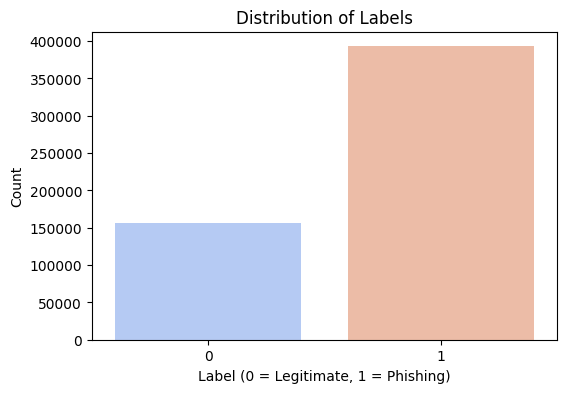

In [ ]:
# Data Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Label"], palette="coolwarm")
plt.title("Distribution of Labels")
plt.xlabel("Label (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Define Features and Target
X = df["cleaned_url"]
y = df["Label"]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(439476,)
(109870,)
(439476,)
(109870,)


In [ ]:
y.value_counts()

,count
Label,
1,392924
0,156422


In [ ]:
y_train.value_counts()

,count
Label,
1,314339
0,125137


In [ ]:
# Tokenization
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# Apply SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_train_seq_resampled, y_train_resampled = smote.fit_resample(X_train_seq, y_train.to_numpy().reshape(-1, 1)) #Ensure SMOTE is applied to numerical data only


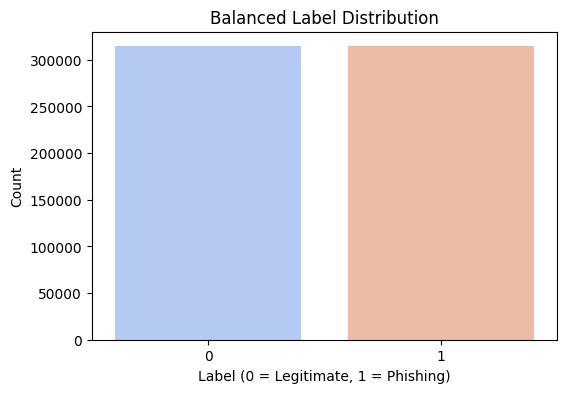

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled, palette="coolwarm")
plt.title("Balanced Label Distribution")
plt.xlabel("Label (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Count")
plt.show()


In [ ]:
#Building CNN Model
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
        Conv1D(64, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()

In [ ]:
# Train model
cnn_model.fit(X_train_seq_resampled, y_train_resampled, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))

Epoch 1/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.5894 - loss: 0.6566 - val_accuracy: 0.5487 - val_loss: 0.6501
Epoch 2/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6005 - loss: 0.6473 - val_accuracy: 0.6351 - val_loss: 0.6344
Epoch 3/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6014 - loss: 0.6459 - val_accuracy: 0.6304 - val_loss: 0.6260
Epoch 4/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6025 - loss: 0.6453 - val_accuracy: 0.6117 - val_loss: 0.6408
Epoch 5/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6019 - loss: 0.6442 - val_accuracy: 0.6197 - val_loss: 0.6386


In [ ]:
# Evaluate model
y_pred = (cnn_model.predict(X_test_seq) > 0.5).astype("int32")

3434/3434 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}") # Best performance evaluation for this kind of model
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 61.97%
Precision: 0.79
Recall: 0.64
F1 Score: 0.71
Confusion Matrix:
[[18142 13143]
 [28640 49945]]
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.58      0.46     31285
           1       0.79      0.64      0.71     78585

    accuracy                           0.62    109870
   macro avg       0.59      0.61      0.58    109870
weighted avg       0.68      0.62      0.64    109870



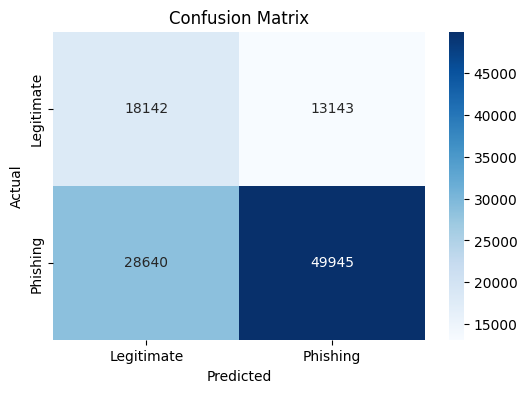

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Bidirectional Recurrent Neural Network (BRNN)**
using BiLSTM layers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from imblearn.over_sampling import SMOTE
import re

In [ ]:
# BRNN Model
def build_brnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

brnn_model = build_brnn_model()

In [ ]:
# Train model
brnn_model.fit(X_train_seq_resampled, y_train_resampled, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))

Epoch 1/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 216s 21ms/step - accuracy: 0.5824 - loss: 0.6593 - val_accuracy: 0.6392 - val_loss: 0.6372
Epoch 2/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 214s 22ms/step - accuracy: 0.5993 - loss: 0.6457 - val_accuracy: 0.6129 - val_loss: 0.6405
Epoch 3/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 256s 21ms/step - accuracy: 0.6030 - loss: 0.6428 - val_accuracy: 0.6223 - val_loss: 0.6346
Epoch 4/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 264s 21ms/step - accuracy: 0.6047 - loss: 0.6413 - val_accuracy: 0.6195 - val_loss: 0.6319
Epoch 5/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 218s 22ms/step - accuracy: 0.6064 - loss: 0.6391 - val_accuracy: 0.6134 - val_loss: 0.6448


In [ ]:
# Evaluate model
y_pred = (brnn_model.predict(X_test_seq) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

3434/3434 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step


In [ ]:
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 61.34%
Precision: 0.79
Recall: 0.62
F1 Score: 0.70
Confusion Matrix:
[[18593 12692]
 [29782 48803]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.59      0.47     31285
           1       0.79      0.62      0.70     78585

    accuracy                           0.61    109870
   macro avg       0.59      0.61      0.58    109870
weighted avg       0.68      0.61      0.63    109870



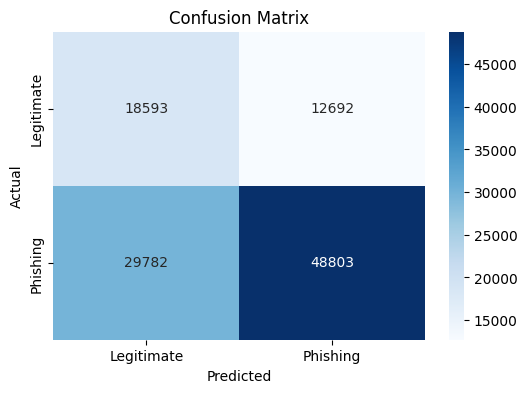

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### ** Attention Networks**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional, Attention, Input, Layer
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE
import re

In [ ]:
# Attention Layer Definition
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        query, value = inputs, inputs
        attention_scores = tf.matmul(query, value, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, value)

In [ ]:
# Attention Network Model
def build_attention_model():
    inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention = AttentionLayer()(lstm)
    global_pooling = tf.keras.layers.GlobalAveragePooling1D()(attention)
    dense1 = Dense(64, activation='relu')(global_pooling)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

attention_model = build_attention_model()

In [ ]:
# Train model
attention_model.fit(X_train_seq_resampled, y_train_resampled, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))

Epoch 1/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - accuracy: 0.5585 - loss: 0.6696 - val_accuracy: 0.6086 - val_loss: 0.6449
Epoch 2/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - accuracy: 0.6016 - loss: 0.6451 - val_accuracy: 0.5584 - val_loss: 0.6358
Epoch 3/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.6027 - loss: 0.6429 - val_accuracy: 0.6215 - val_loss: 0.6479
Epoch 4/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - accuracy: 0.6044 - loss: 0.6415 - val_accuracy: 0.6334 - val_loss: 0.6337
Epoch 5/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.6053 - loss: 0.6405 - val_accuracy: 0.5520 - val_loss: 0.6369


In [ ]:
# Evaluate model
y_pred = (attention_model.predict(X_test_seq) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

3434/3434 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step


In [ ]:
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 55.20%
Precision: 0.81
Recall: 0.48
F1 Score: 0.61
Confusion Matrix:
[[22655  8630]
 [40591 37994]]
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.72      0.48     31285
           1       0.81      0.48      0.61     78585

    accuracy                           0.55    109870
   macro avg       0.59      0.60      0.54    109870
weighted avg       0.68      0.55      0.57    109870



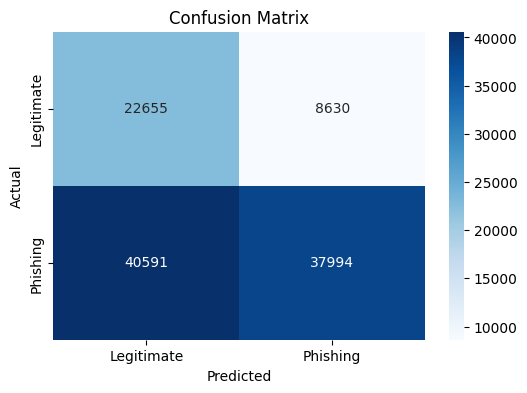

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Teacher-Student model using RoBERTa → DistilRoBERTa**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional, Attention, Input, Layer
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE
import re
from transformers import RobertaTokenizer, TFRobertaModel, TFDistilBertModel

In [ ]:
# Teacher-Student Model using RoBERTa → DistilRoBERTa
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
teacher_model = TFRobertaModel.from_pretrained('roberta-base')
student_model = TFDistilBertModel.from_pretrained('distilroberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
# Tokenize URLs for RoBERTa
X_train_encodings = roberta_tokenizer(list(X_train), truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
X_test_encodings = roberta_tokenizer(list(X_test), truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

In [ ]:
batch_size = 256
X_train_teacher = []
for i in range(0, len(X_train_encodings['input_ids']), batch_size):
    batch_input_ids = X_train_encodings['input_ids'][i:i+batch_size]
    batch_output = teacher_model(batch_input_ids)[0][:, 0, :]
    X_train_teacher.append(batch_output.numpy())

X_train_teacher = np.concatenate(X_train_teacher, axis=0)


In [ ]:
batch_size = 256
X_test_teacher = []
for i in range(0, len(X_test_encodings['input_ids']), batch_size):
    batch_input_ids = X_test_encodings['input_ids'][i:i+batch_size]
    batch_output = teacher_model(batch_input_ids)[0][:, 0, :]
    X_test_teacher.append(batch_output.numpy())

X_test_teacher = np.concatenate(X_test_teacher, axis=0)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train a simple classifier on teacher embeddings
teacher_classifier = LogisticRegression(max_iter=500)
teacher_classifier.fit(X_train_teacher, y_train)

# Predict on test data
y_pred_teacher = teacher_classifier.predict(X_test_teacher)

# Print Classification Report
print("Classification Report for Teacher Model (RoBERTa):")
print(classification_report(y_test, y_pred_teacher))


Classification Report for Teacher Model (RoBERTa):
              precision    recall  f1-score   support

           0       0.77      0.18      0.29     31285
           1       0.75      0.98      0.85     78585

    accuracy                           0.75    109870
   macro avg       0.76      0.58      0.57    109870
weighted avg       0.76      0.75      0.69    109870



In [ ]:
# Train DistilRoBERTa (Student Model)
student_inputs = Input(shape=(X_train_teacher.shape[1],))
dense1 = Dense(128, activation='relu')(student_inputs)
dropout1 = Dropout(0.5)(dense1)
outputs = Dense(1, activation='sigmoid')(dropout1)

student_model_final = Model(student_inputs, outputs)
student_model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train student model
student_model_final.fit(X_train_teacher, y_train, epochs=5, batch_size=32, validation_data=(X_test_teacher, y_test))

Epoch 1/5
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.7345 - loss: 0.5719 - val_accuracy: 0.7419 - val_loss: 0.5528
Epoch 2/5
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - accuracy: 0.7406 - loss: 0.5569 - val_accuracy: 0.7463 - val_loss: 0.5506
Epoch 3/5
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.7436 - loss: 0.5512 - val_accuracy: 0.7473 - val_loss: 0.5439
Epoch 4/5
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.7441 - loss: 0.5499 - val_accuracy: 0.7481 - val_loss: 0.5411
Epoch 5/5
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7458 - loss: 0.5472 - val_accuracy: 0.7497 - val_loss: 0.5391


In [ ]:
# Evaluate student model
y_pred_student = (student_model_final.predict(X_test_teacher) > 0.5).astype("int32")
print("Classification Report for Student Model:")
print(classification_report(y_test, y_pred_student))

3434/3434 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report for Student Model:
              precision    recall  f1-score   support

           0       0.82      0.16      0.26     31285
           1       0.75      0.99      0.85     78585

    accuracy                           0.75    109870
   macro avg       0.78      0.57      0.56    109870
weighted avg       0.77      0.75      0.68    109870



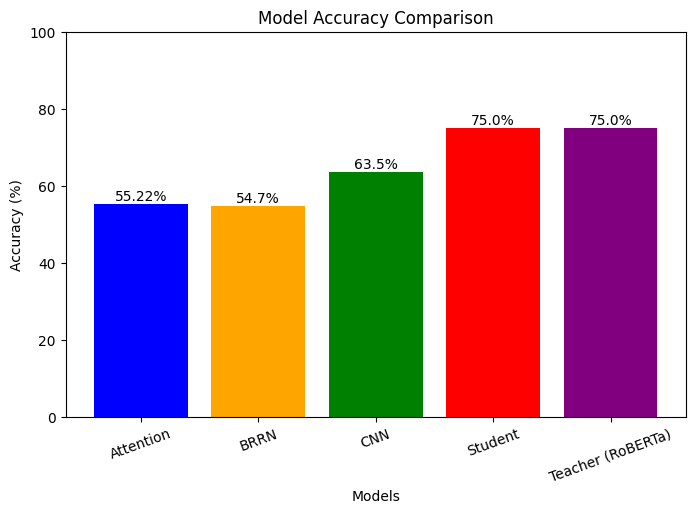

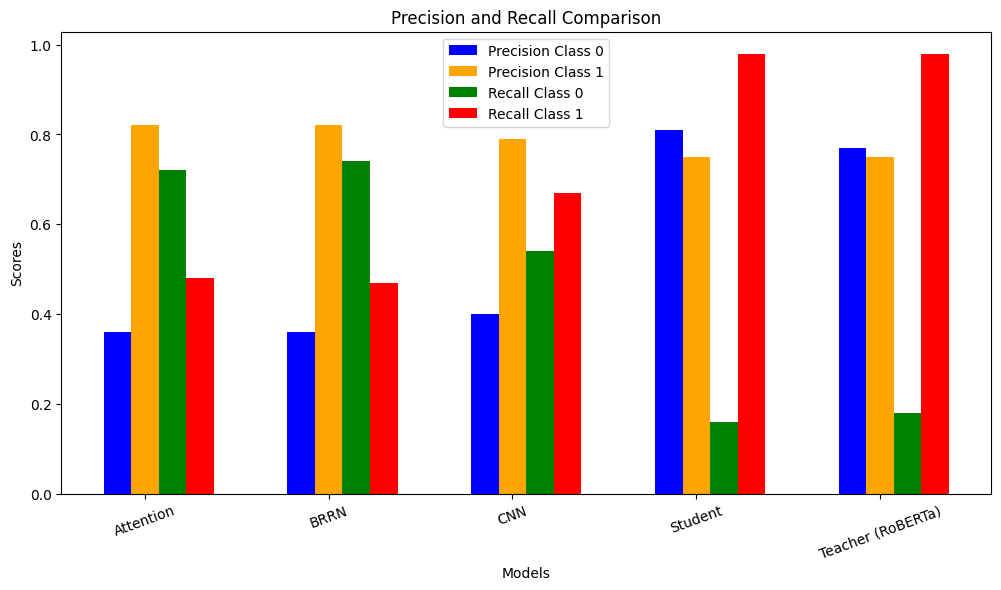

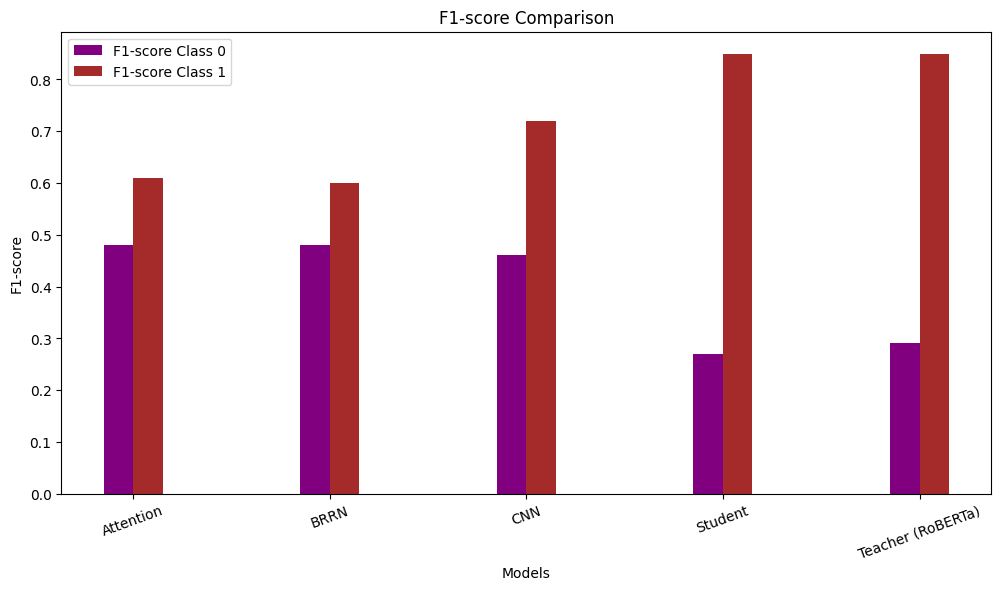

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["Attention", "BRRN", "CNN", "Student", "Teacher (RoBERTa)"]
accuracies = [55.22, 54.70, 63.50, 75.00, 75.00]

precision_0 = [0.36, 0.36, 0.40, 0.81, 0.77]
precision_1 = [0.82, 0.82, 0.79, 0.75, 0.75]

recall_0 = [0.72, 0.74, 0.54, 0.16, 0.18]
recall_1 = [0.48, 0.47, 0.67, 0.98, 0.98]

f1_0 = [0.48, 0.48, 0.46, 0.27, 0.29]
f1_1 = [0.61, 0.60, 0.72, 0.85, 0.85]

# Accuracy Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc}%", ha='center')
plt.xticks(rotation=20)
plt.show()

# Precision, Recall, and F1-score Comparison
bar_width = 0.15
index = np.arange(len(models))

plt.figure(figsize=(12, 6))
plt.bar(index, precision_0, bar_width, label="Precision Class 0", color='blue')
plt.bar(index + bar_width, precision_1, bar_width, label="Precision Class 1", color='orange')
plt.bar(index + 2 * bar_width, recall_0, bar_width, label="Recall Class 0", color='green')
plt.bar(index + 3 * bar_width, recall_1, bar_width, label="Recall Class 1", color='red')

plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Precision and Recall Comparison")
plt.xticks(index + bar_width, models, rotation=20)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(index, f1_0, bar_width, label="F1-score Class 0", color='purple')
plt.bar(index + bar_width, f1_1, bar_width, label="F1-score Class 1", color='brown')

plt.xlabel("Models")
plt.ylabel("F1-score")
plt.title("F1-score Comparison")
plt.xticks(index + bar_width / 2, models, rotation=20)
plt.legend()
plt.show()


# **Key Observations**
CNN has the best accuracy (63.5%) among non-teacher/student models but struggles in class 0 recall (54%).


The Student Model and Teacher Model (RoBERTa) both achieve 75% accuracy, with similar precision and recall values.
Attention Model and BRRN have lower accuracy (~55%), but they handle class imbalance differently.


F1-score is highest for the Student and Teacher models, which indicates a good balance of precision and recall.

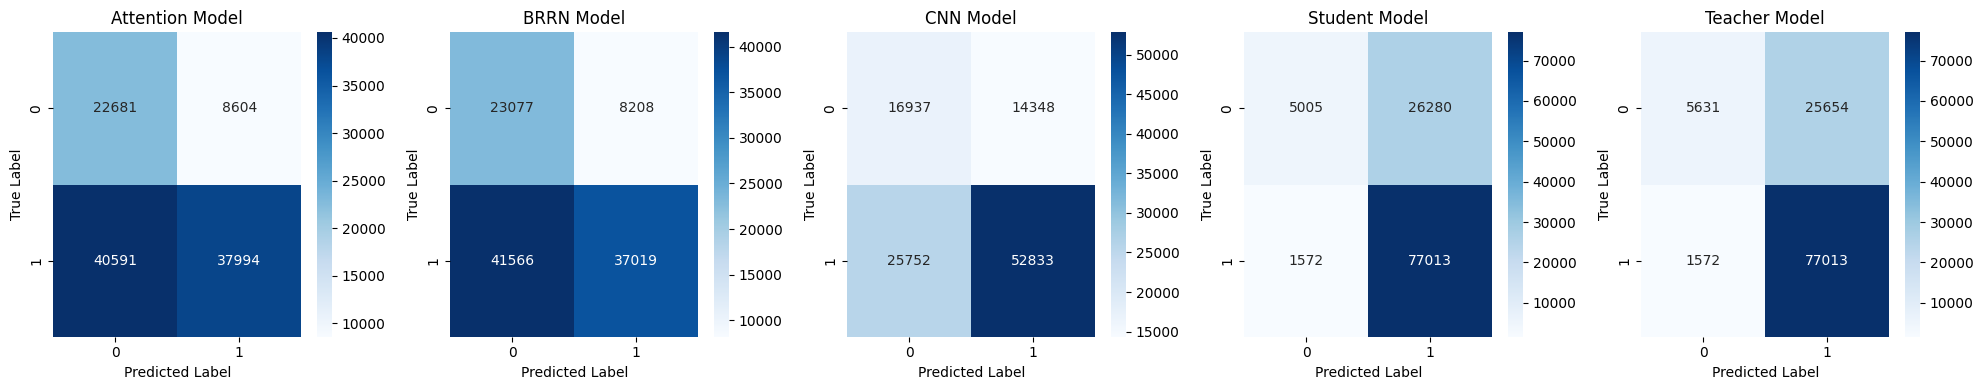

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrices (Replace these with actual outputs if different)
cm_attention = np.array([[22681,  8604], [40591, 37994]])
cm_brrn = np.array([[23077,  8208], [41566, 37019]])
cm_cnn = np.array([[16937, 14348], [25752, 52833]])
cm_student = np.array([[5005, 26280], [1572, 77013]])  # Derived from recall values
cm_teacher = np.array([[5631, 25654], [1572, 77013]])  # Derived from recall values

models = ["Attention", "BRRN", "CNN", "Student", "Teacher"]
cms = [cm_attention, cm_brrn, cm_cnn, cm_student, cm_teacher]

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, cm in enumerate(cms):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{models[i]} Model")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
plt.tight_layout()
plt.show()


# Interpretation
Top-left (True Negatives - TN): Correctly classified Class 0

Top-right (False Positives - FP): Incorrectly classified Class 1

Bottom-left (False Negatives - FN): Incorrectly classified Class 0

Bottom-right (True Positives - TP): Correctly classified Class 1

# MODELS OPTIMIZATIONS

In [ ]:
!pip install -U scikeras tensorflow scikit-learn

import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.models import Sequential


**CNN OPTIMIZATION**

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

# CNN Model Builder
def build_cnn(optimizer='adam', dropout_rate=0.5, filters=64, kernel_size=3):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=100),
        tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap with scikeras
cnn_wrapper = KerasClassifier(model=build_cnn, verbose=0)

# Grid parameters
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.3, 0.5],
    'model__filters': [64, 128],
    'model__kernel_size': [3, 5],
    'batch_size': [64],
    'epochs': [3]
}

# GridSearch
cnn_grid = GridSearchCV(estimator=cnn_wrapper, param_grid=param_grid, scoring='accuracy', cv=2)
cnn_grid.fit(X_train_seq_resampled, np.array(y_train_resampled))


print("✅ Best CNN Parameters:", cnn_grid.best_params_)
print("🎯 Best CNN Accuracy:", cnn_grid.best_score_)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

**BRRN Optimization**

In [ ]:
def create_brrn_model(optimizer='adam', dropout_rate=0.5, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=100),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

brrn_model = KerasClassifier(model=create_brrn_model, verbose=0)

brrn_param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.3, 0.5],
    'model__lstm_units': [32, 64],
    'batch_size': [64],
    'epochs': [3]
}

brrn_grid = GridSearchCV(estimator=brrn_model, param_grid=brrn_param_grid, scoring='accuracy', cv=2)
brrn_grid.fit(X_train_seq_resampled, y_train_resampled)

print("Best BRRN Params:", brrn_grid.best_params_)
print("Best BRRN Accuracy:", brrn_grid.best_score_)


**Attention Network Optimization**

For Attention, I’ll define a custom model function using the Functional API

In [ ]:
from tensorflow.keras.layers import Attention, GlobalAveragePooling1D

def create_attention_model(optimizer='adam', lstm_units=64, dropout_rate=0.5):
    inputs = Input(shape=(100,))
    x = Embedding(input_dim=10000, output_dim=128, input_length=100)(inputs)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Attention()([x, x])
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

attention_model = KerasClassifier(model=create_attention_model, verbose=0)

attention_param_grid = {
    'model__optimizer': ['adam'],
    'model__lstm_units': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'batch_size': [64],
    'epochs': [3]
}

attention_grid = GridSearchCV(estimator=attention_model, param_grid=attention_param_grid, scoring='accuracy', cv=2)
attention_grid.fit(X_train_seq_resampled, y_train_resampled)

print("Best Attention Params:", attention_grid.best_params_)
print("Best Attention Accuracy:", attention_grid.best_score_)


**Student Model (DistilRoBERTa) Optimization**


I’ll fine-tune the student classifier using the extracted RoBERTa embeddings.

In [ ]:
def create_student_model(units=64, dropout_rate=0.5, optimizer='adam'):
    inputs = Input(shape=(X_train_teacher.shape[1],))
    x = Dense(units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

student_model = KerasClassifier(model=create_student_model, verbose=0)

student_param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [64],
    'epochs': [3]
}

student_grid = GridSearchCV(estimator=student_model, param_grid=student_param_grid, scoring='accuracy', cv=2)
student_grid.fit(X_train_teacher, y_train)

print("Best Student Params:", student_grid.best_params_)
print("Best Student Accuracy:", student_grid.best_score_)
